## Includes

In [1]:
import sys
import os
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', 400)

import canalyst_candas.candas as cd
import canalyst_candas.candas_datareader as cdr
from canalyst_candas.configuration.config import Config


config_info = {
  "canalyst_api_key": "",
   "s3_access_key_id": "",
    "s3_secret_key": "",
  "fred_key": "",
  "default_dir": "",
  "mds_host": "",
  "wp_host": ""
}

config = Config(config=config_info)

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

A configuration file has been created for you in 
/Users/jedgore/canalyst/keys.json.


# Example: Redrive One Model With Another Model
## Workflow:
<li>Find common correlated time series between two companies
<li>Create ModelSet for one "source" ticker
<li>Create ModelSet for second "target" ticker
<li>Regress Key Drivers
<li>Apply filters to regression output from the control switches below
<li>Get new forecast values for second ticker based on individual regression formulas
<li>Redrive second model and display new values vs old

## Control Switches: 
### Change ticker as needed etc

In [2]:
source_ticker = "V US"
target_ticker = "SQ US"
return_series = "MO_RIS_REV" 
#return series variable is used in the model map end node AND the return value from fit()
#use MO_RIS_EPS_WAD_Adj for EPS
modelmap_node_distance = 2
minimum_periods = 3
minimum_rsquared = .75

## Create ModelSet

In [3]:
source_modelset = cd.ModelSet(ticker_list=[source_ticker],config=config)
target_modelset = cd.ModelSet(ticker_list=[target_ticker],config=config)

## Create ModelMap and show() it

In [4]:
time_series_name=return_series
model_map = target_modelset.create_model_map(ticker=target_ticker,
                            time_series_name=time_series_name,
                            tree = True,
                            notebook = True,
                            col_for_labels = "time_series_description") #change to time_series_name to see range names
model_map.show()

https://mds.canalyst.com/api/equity-model-series/8MPZ580137/equity-models/FY2021.24/time-series/MO_RIS_REV/forecast-data-points/Q1-2022/drivers/?format=dot


<AxesSubplot:title={'center':'SQ US Revenue Mix'}>

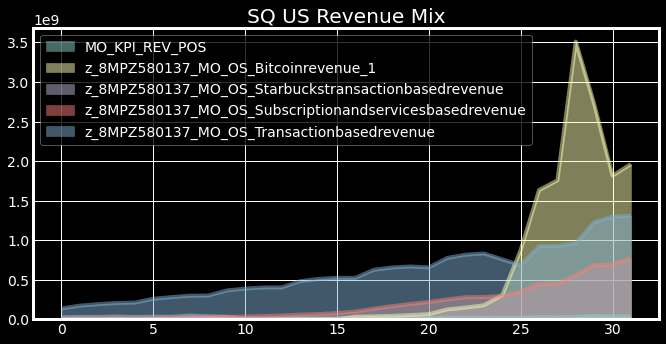

In [5]:
#credit David Braverman of System2 for this idea
node_df = model_map.create_node_df()
node_df["nodes_at_level"] = node_df.groupby("distance_to_root")["time_series_name"].transform("count")
ts_segments = node_df[node_df["distance_to_root"] == modelmap_node_distance]["time_series_name"].to_list()
df = target_modelset.model_frame(ticker=target_ticker,
                                period_duration_type='fiscal_quarter',
                               time_series_name=ts_segments)
df
df = cd.unstack_dataframe(df,period_type='period_name_sorted').dropna()
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [10, 5]
df.plot(kind='area', stacked=False,title=target_ticker+" Revenue Mix")

## Get the Key Drivers list from ModelMap

In [6]:
source_key_drivers = list(set(list(source_modelset.models[source_ticker].key_driver_map(return_series)['time_series_name'])))
target_key_drivers = list(set(list(target_modelset.models[target_ticker].key_driver_map(return_series)['time_series_name'])))

https://mds.canalyst.com/api/equity-model-series/2CRCA60110/equity-models/Q1-2022.22/time-series/MO_RIS_REV/forecast-data-points/Q2-2022/drivers/?format=dot
https://mds.canalyst.com/api/equity-model-series/8MPZ580137/equity-models/FY2021.24/time-series/MO_RIS_REV/forecast-data-points/Q1-2022/drivers/?format=dot


## Create a view of forecasted Key Drivers

In [7]:
target_modelset.model_frame(time_series_name=target_key_drivers,
                       is_historical=False,
                       period_duration_type="fiscal_quarter",
                       pivot=True)

period_name_sorted,ticker,name_index,category,time_series_name,time_series_description,is_driver,MRFQ,2022Q1,2022Q2,2022Q3,2022Q4,2023Q1,2023Q2,2023Q3,2023Q4
0,SQ US,9,Operating Stats - Gross Payment Volume (MD&A),z_8MPZ580137_MO_OS_SellerGPVGrowthRate,"Y/Y Seller GPV Growth Rate, %",True,Q4-2021,15.00,15.00,15.00,15.00,12.00,12.00,12.00,12.00
1,SQ US,12,Operating Stats - Gross Payment Volume (MD&A),z_8MPZ580137_MO_OS_CashAppGPVGrowthRate,"Y/Y Cash App GPV Growth Rate, %",True,Q4-2021,80.00,80.00,80.00,80.00,50.00,50.00,50.00,50.00
2,SQ US,18,Operating Stats - Gross Payment Volume (MD&A),z_8MPZ580137_MO_OS_SellerTransactionbasedRevenueasapercentageofGPV,"Seller Transaction-based Revenue as a percentage of GPV, %",True,Q4-2021,3.25,3.25,3.25,3.25,3.25,3.25,3.25,3.25
3,SQ US,19,Operating Stats - Gross Payment Volume (MD&A),z_8MPZ580137_MO_OS_CashAppTransactionbasedRevenueasapercentageofGPV,"Cash App Transaction-based Revenue as a percentage of GPV, %",True,Q4-2021,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00
4,SQ US,39,Segmented Results - Revenue Breakdown (FS),z_8MPZ580137_MO_GA_CashAppSubscriptionandservicesbasedrevenuegrowth,"Y/Y Cash App Subscription and services-based revenue growth, %",True,Q4-2021,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00
5,SQ US,42,Segmented Results - Revenue Breakdown (FS),z_8MPZ580137_MO_GA_SellerEcosystemSubscriptionandservicesbasedrevenuegrowth,"Y/Y Seller Ecosystem Subscription and services-based revenue growth, %",True,Q4-2021,30.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00
6,SQ US,43,Segmented Results - Revenue Breakdown (FS),z_8MPZ580137_MO_OS_CorporateandOtherSubscriptionandservicesbasedrevenue,"Corporate and Other Subscription and services-based revenue, mm",True,Q4-2021,60000000.00,62388800.00,60532500.00,58498650.00,63000000.00,65508240.00,63559125.00,61423582.50
7,SQ US,52,Segmented Results - Revenue Breakdown (FS),z_8MPZ580137_MO_OS_Bitcoinrevenue,"Y/Y Bitcoin revenue growth, %",True,Q4-2021,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00
8,SQ US,56,Segmented Results - Revenue Breakdown (FS),z_8MPZ580137_MO_OS_Hardwarerevenuegrowth,"Y/Y Hardware revenue growth, %",True,Q4-2021,15.00,15.00,15.00,15.00,15.00,15.00,15.00,15.00


In [8]:
#regress all key drivers against all key drivers
df_target = target_modelset.model_frame(time_series_name=target_key_drivers,
                                       is_historical=True,
                                       period_duration_type="fiscal_quarter")
df_source = source_modelset.model_frame(time_series_name=source_key_drivers,
                                       is_historical=True,
                                       period_duration_type="fiscal_quarter")

In [9]:
import statsmodels.formula.api as smf
import warnings
warnings.simplefilter("ignore")

#get list of low p value high r sq drivers
df_out = []
df_models={}
for target_driver in target_key_drivers:
    df1 = df_target.loc[df_target['time_series_name']==target_driver][['period_end_date','value','time_series_name']]
    for source_driver in source_key_drivers:
        df2 = df_source.loc[df_source['time_series_name']==source_driver][['period_end_date','value','time_series_name']]
        df2 = pd.merge(df1,df2,how='inner',left_on='period_end_date',right_on='period_end_date')
        df2 = df2.dropna()
        model = smf.ols(formula="value_x ~ value_y", data=df2)
        rres = model.fit()
        d = {}
        d = {"source_driver":source_driver,
             "target_driver":target_driver,
            "intercept":[rres.params[0]],
             "n_periods":[df2.shape[0]],
            "rsquared":[rres.rsquared],
            "slope":[rres.params[1]],
            "pvalue":[rres.pvalues[1]]}
        df = pd.DataFrame(d)       
        df_out.append(df)
        df_models[target_driver]=model
df_regression = pd.concat(df_out)
df_regression = df_regression.sort_values('rsquared',ascending=False).dropna()
df_regression = df_regression.groupby('target_driver').first().reset_index().sort_values('rsquared',ascending=False)

In [10]:
df_regression

,target_driver,source_driver,intercept,n_periods,rsquared,slope,pvalue
5,z_8MPZ580137_MO_OS_CorporateandOtherSubscriptionandservicesbasedrevenue,z_2CRCA60110_MO_OS_YYChangeinDataprocessingrevenueperprocessedtransactions,64107633.03,3,1.00,4982159.04,0.02
7,z_8MPZ580137_MO_OS_SellerGPVGrowthRate,z_2CRCA60110_MO_OS_YYChangeinVisaprocessedtransactionspercard,-0.84,6,0.99,2.22,0.00
1,z_8MPZ580137_MO_GA_SellerEcosystemSubscriptionandservicesbasedrevenuegrowth,z_2CRCA60110_MO_GA_ConstantCrossborderVolumeexclIntraEurope,40.08,8,0.96,1.16,0.00
0,z_8MPZ580137_MO_GA_CashAppSubscriptionandservicesbasedrevenuegrowth,z_2CRCA60110_MO_GA_ConstantCrossborderVolumeexclIntraEurope,97.88,8,0.81,-0.88,0.00
3,z_8MPZ580137_MO_OS_CashAppGPVGrowthRate,z_2CRCA60110_MO_GA_ConstantCrossborderVolumeexclIntraEurope,192.61,6,0.76,-2.71,0.02
2,z_8MPZ580137_MO_OS_Bitcoinrevenue,z_2CRCA60110_MO_GA_ConstantCrossborderVolumeexclIntraEurope,467.00,11,0.72,-8.92,0.00
6,z_8MPZ580137_MO_OS_Hardwarerevenuegrowth,z_2CRCA60110_MO_GA_ImpliedFXimpactCrossborderVolumeexclIntraEurope,22.74,7,0.70,10.17,0.02
8,z_8MPZ580137_MO_OS_SellerTransactionbasedRevenueasapercentageofGPV,z_2CRCA60110_MO_OS_YYChangeinDataprocessingrevenueperprocessedtransactions,2.89,10,0.58,0.01,0.01
4,z_8MPZ580137_MO_OS_CashAppTransactionbasedRevenueasapercentageofGPV,z_2CRCA60110_MO_GA_ImpliedFXimpactCrossborderVolumeexclIntraEurope,2.77,7,0.25,-0.01,0.25


In [11]:
#use the same node tree to extract key drivers (red nodes)
return_series = 'MO_RIS_REV'
driver_list_df = []
for target_driver in target_key_drivers:

    time_series_name = target_driver
    print(f"scenario: move {time_series_name} 1% and get resultant change in {return_series}")

    #create a param dataframe for each time series name in our list
    df_1_param = target_modelset.forecast_frame(time_series_name,
                         n_periods=-1,
                         function_name='multiply',
                         function_value=1.01)

    d_output=target_modelset.fit(df_1_param,return_series) #our fit function will return a link to scenario engine JSON for audit

    df_output = target_modelset.filter_summary(d_output,period_type='Q')

    df_merge = pd.merge(df_output,df_1_param,how='inner',left_on=['ticker','period_name'],right_on=['ticker','period_name'])

    driver_list_df.append(df_merge) #append to a list for concatenating at the end
df = pd.concat(driver_list_df).sort_values('diff',ascending=False)
df = df.rename(columns={'time_series_name_y':'time_series_name'})
df['diff'] = df['diff']-1
df = df.sort_values('diff')

scenario: move z_8MPZ580137_MO_OS_CashAppTransactionbasedRevenueasapercentageofGPV 1% and get resultant change in MO_RIS_REV
SQ US scenario_id_url: https://mds.canalyst.com/api/equity-model-series/8MPZ580137/equity-models/FY2021.24/scenarios/2UpWW2f3W3-ECDAFgJ8CIw/
scenario: move z_8MPZ580137_MO_OS_Bitcoinrevenue 1% and get resultant change in MO_RIS_REV
SQ US scenario_id_url: https://mds.canalyst.com/api/equity-model-series/8MPZ580137/equity-models/FY2021.24/scenarios/vI3PzVJeW2OwB0uFxg90EQ/
scenario: move z_8MPZ580137_MO_GA_SellerEcosystemSubscriptionandservicesbasedrevenuegrowth 1% and get resultant change in MO_RIS_REV
SQ US scenario_id_url: https://mds.canalyst.com/api/equity-model-series/8MPZ580137/equity-models/FY2021.24/scenarios/WlpTG0OTUleBC4XIheDc7Q/
scenario: move z_8MPZ580137_MO_OS_CashAppGPVGrowthRate 1% and get resultant change in MO_RIS_REV
SQ US scenario_id_url: https://mds.canalyst.com/api/equity-model-series/8MPZ580137/equity-models/FY2021.24/scenarios/GGVkowq5VfKaFD

<AxesSubplot:title={'center':'SQ US Key Drivers Revenue Sensitivity'}, ylabel='time_series_name'>

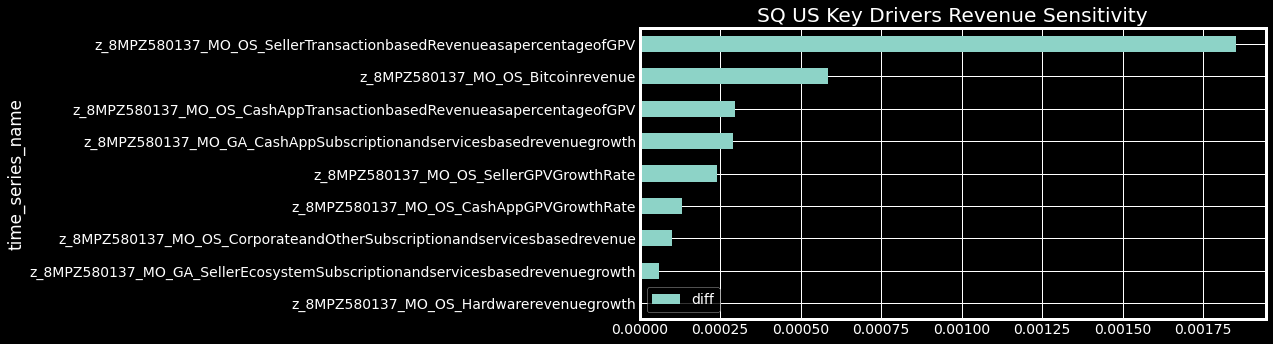

In [12]:
df.sort_values('diff',ascending=True).plot(x='time_series_name',y='diff',kind='barh',title=target_ticker+" Key Drivers Revenue Sensitivity")

In [13]:
df_forecast = target_modelset.model_frame(time_series_name=target_key_drivers,
                       is_historical=False,
                       period_duration_type="fiscal_quarter",
                       pivot=True)
df_forecast

period_name_sorted,ticker,name_index,category,time_series_name,time_series_description,is_driver,MRFQ,2022Q1,2022Q2,2022Q3,2022Q4,2023Q1,2023Q2,2023Q3,2023Q4
0,SQ US,9,Operating Stats - Gross Payment Volume (MD&A),z_8MPZ580137_MO_OS_SellerGPVGrowthRate,"Y/Y Seller GPV Growth Rate, %",True,Q4-2021,15.00000,15.00000,15.00000,15.00000,12.00000,12.00000,12.00000,12.00000
1,SQ US,12,Operating Stats - Gross Payment Volume (MD&A),z_8MPZ580137_MO_OS_CashAppGPVGrowthRate,"Y/Y Cash App GPV Growth Rate, %",True,Q4-2021,80.00000,80.00000,80.00000,80.00000,50.00000,50.00000,50.00000,50.00000
2,SQ US,18,Operating Stats - Gross Payment Volume (MD&A),z_8MPZ580137_MO_OS_SellerTransactionbasedRevenueasapercentageofGPV,"Seller Transaction-based Revenue as a percentage of GPV, %",True,Q4-2021,3.25000,3.25000,3.25000,3.25000,3.25000,3.25000,3.25000,3.25000
3,SQ US,19,Operating Stats - Gross Payment Volume (MD&A),z_8MPZ580137_MO_OS_CashAppTransactionbasedRevenueasapercentageofGPV,"Cash App Transaction-based Revenue as a percentage of GPV, %",True,Q4-2021,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000
4,SQ US,39,Segmented Results - Revenue Breakdown (FS),z_8MPZ580137_MO_GA_CashAppSubscriptionandservicesbasedrevenuegrowth,"Y/Y Cash App Subscription and services-based revenue growth, %",True,Q4-2021,40.00000,40.00000,40.00000,40.00000,40.00000,40.00000,40.00000,40.00000
5,SQ US,42,Segmented Results - Revenue Breakdown (FS),z_8MPZ580137_MO_GA_SellerEcosystemSubscriptionandservicesbasedrevenuegrowth,"Y/Y Seller Ecosystem Subscription and services-based revenue growth, %",True,Q4-2021,30.00000,30.00000,30.00000,30.00000,30.00000,30.00000,30.00000,30.00000
6,SQ US,43,Segmented Results - Revenue Breakdown (FS),z_8MPZ580137_MO_OS_CorporateandOtherSubscriptionandservicesbasedrevenue,"Corporate and Other Subscription and services-based revenue, mm",True,Q4-2021,60000000.00000,62388800.00000,60532500.00000,58498650.00000,63000000.00000,65508240.00000,63559125.00000,61423582.50000
7,SQ US,52,Segmented Results - Revenue Breakdown (FS),z_8MPZ580137_MO_OS_Bitcoinrevenue,"Y/Y Bitcoin revenue growth, %",True,Q4-2021,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000
8,SQ US,56,Segmented Results - Revenue Breakdown (FS),z_8MPZ580137_MO_OS_Hardwarerevenuegrowth,"Y/Y Hardware revenue growth, %",True,Q4-2021,15.00000,15.00000,15.00000,15.00000,15.00000,15.00000,15.00000,15.00000


## Modify Key Drivers by our regression results

In [14]:
df_regression.loc[df_regression['n_periods']>minimum_periods]
df_regression.loc[df_regression['rsquared']>minimum_rsquared]

,target_driver,source_driver,intercept,n_periods,rsquared,slope,pvalue
5,z_8MPZ580137_MO_OS_CorporateandOtherSubscriptionandservicesbasedrevenue,z_2CRCA60110_MO_OS_YYChangeinDataprocessingrevenueperprocessedtransactions,64107633.03131,3,0.99905,4982159.03846,0.01958
7,z_8MPZ580137_MO_OS_SellerGPVGrowthRate,z_2CRCA60110_MO_OS_YYChangeinVisaprocessedtransactionspercard,-0.83632,6,0.99435,2.21542,0.00001
1,z_8MPZ580137_MO_GA_SellerEcosystemSubscriptionandservicesbasedrevenuegrowth,z_2CRCA60110_MO_GA_ConstantCrossborderVolumeexclIntraEurope,40.08259,8,0.95865,1.16444,0.00002
0,z_8MPZ580137_MO_GA_CashAppSubscriptionandservicesbasedrevenuegrowth,z_2CRCA60110_MO_GA_ConstantCrossborderVolumeexclIntraEurope,97.87771,8,0.80611,-0.88403,0.00247
3,z_8MPZ580137_MO_OS_CashAppGPVGrowthRate,z_2CRCA60110_MO_GA_ConstantCrossborderVolumeexclIntraEurope,192.61399,6,0.76194,-2.71359,0.02321


## Run the ModelSet.fit() function to re drive the model
### "Default" is the model current default, "Scenario" shows our changes

In [15]:
df_regression = df_regression.loc[df_regression['n_periods']>minimum_periods]
df_regression = df_regression.loc[df_regression['rsquared']>minimum_rsquared]
df_params = target_modelset.model_frame(time_series_name=target_key_drivers,
                       is_historical=False,
                       period_duration_type="fiscal_quarter",
                       pivot=False)
df_params = df_params[['ticker','time_series_name','time_series_description','period_name','value']]
df_params = pd.merge(df_params,df_regression,how='inner',left_on='time_series_name',right_on='target_driver')
df_params['new_value'] = df_params['value']*df_params['slope']+df_params['intercept']
df_params = df_params[['ticker','time_series_name','time_series_description','period_name','value','new_value']]

In [16]:
df_params.head()

,ticker,time_series_name,time_series_description,period_name,value,new_value
0,SQ US,z_8MPZ580137_MO_GA_SellerEcosystemSubscriptionandservicesbasedrevenuegrowth,"Y/Y Seller Ecosystem Subscription and services-based revenue growth, %",Q1-2022,30.00000,75.01588
1,SQ US,z_8MPZ580137_MO_GA_SellerEcosystemSubscriptionandservicesbasedrevenuegrowth,"Y/Y Seller Ecosystem Subscription and services-based revenue growth, %",Q2-2022,30.00000,75.01588
2,SQ US,z_8MPZ580137_MO_GA_SellerEcosystemSubscriptionandservicesbasedrevenuegrowth,"Y/Y Seller Ecosystem Subscription and services-based revenue growth, %",Q3-2022,30.00000,75.01588
3,SQ US,z_8MPZ580137_MO_GA_SellerEcosystemSubscriptionandservicesbasedrevenuegrowth,"Y/Y Seller Ecosystem Subscription and services-based revenue growth, %",Q4-2022,30.00000,75.01588
4,SQ US,z_8MPZ580137_MO_GA_SellerEcosystemSubscriptionandservicesbasedrevenuegrowth,"Y/Y Seller Ecosystem Subscription and services-based revenue growth, %",Q1-2023,30.00000,75.01588


In [17]:
df_output= target_modelset.fit(df_params,return_series) #our fit function will return a link to scenario engine JSON for audit
df_output = target_modelset.filter_summary(df_output,period_type='Q')

SQ US scenario_id_url: https://mds.canalyst.com/api/equity-model-series/8MPZ580137/equity-models/FY2021.24/scenarios/ldv9h8SFWaGrDdc_5oDlnA/


In [18]:
df_output

,ticker,period_name,time_series_name,time_series_description,default,scenario,diff
0,SQ US,Q1-2022,MO_RIS_REV,Net Revenue,6017550265.37500,6235112517.1509,1.03615
1,SQ US,Q2-2022,MO_RIS_REV,Net Revenue,5670851283.18750,5934058379.5703,1.04641
2,SQ US,Q3-2022,MO_RIS_REV,Net Revenue,4734549089.93000,5036898670.0631,1.06386
3,SQ US,Q4-2022,MO_RIS_REV,Net Revenue,5030668897.63500,5368450333.9288,1.06714
4,SQ US,Q1-2023,MO_RIS_REV,Net Revenue,6926683599.74000,7605030622.1797,1.09793
5,SQ US,Q2-2023,MO_RIS_REV,Net Revenue,6605852907.39000,7428126626.3324,1.12448
6,SQ US,Q3-2023,MO_RIS_REV,Net Revenue,5558470834.17520,6451490470.9576,1.16066
7,SQ US,Q4-2023,MO_RIS_REV,Net Revenue,5908921958.32640,6909420793.714,1.16932


In [19]:
df_regression

,target_driver,source_driver,intercept,n_periods,rsquared,slope,pvalue
7,z_8MPZ580137_MO_OS_SellerGPVGrowthRate,z_2CRCA60110_MO_OS_YYChangeinVisaprocessedtransactionspercard,-0.83632,6,0.99435,2.21542,0.00001
1,z_8MPZ580137_MO_GA_SellerEcosystemSubscriptionandservicesbasedrevenuegrowth,z_2CRCA60110_MO_GA_ConstantCrossborderVolumeexclIntraEurope,40.08259,8,0.95865,1.16444,0.00002
0,z_8MPZ580137_MO_GA_CashAppSubscriptionandservicesbasedrevenuegrowth,z_2CRCA60110_MO_GA_ConstantCrossborderVolumeexclIntraEurope,97.87771,8,0.80611,-0.88403,0.00247
3,z_8MPZ580137_MO_OS_CashAppGPVGrowthRate,z_2CRCA60110_MO_GA_ConstantCrossborderVolumeexclIntraEurope,192.61399,6,0.76194,-2.71359,0.02321


In [20]:
df_params[df_params['period_name']=='Q1-2022']

,ticker,time_series_name,time_series_description,period_name,value,new_value
0,SQ US,z_8MPZ580137_MO_GA_SellerEcosystemSubscriptionandservicesbasedrevenuegrowth,"Y/Y Seller Ecosystem Subscription and services-based revenue growth, %",Q1-2022,30.00000,75.01588
8,SQ US,z_8MPZ580137_MO_OS_CashAppGPVGrowthRate,"Y/Y Cash App GPV Growth Rate, %",Q1-2022,80.00000,-24.47319
16,SQ US,z_8MPZ580137_MO_OS_SellerGPVGrowthRate,"Y/Y Seller GPV Growth Rate, %",Q1-2022,15.00000,32.39499
24,SQ US,z_8MPZ580137_MO_GA_CashAppSubscriptionandservicesbasedrevenuegrowth,"Y/Y Cash App Subscription and services-based revenue growth, %",Q1-2022,40.00000,62.51666


In [21]:
df_output

,ticker,period_name,time_series_name,time_series_description,default,scenario,diff
0,SQ US,Q1-2022,MO_RIS_REV,Net Revenue,6017550265.37500,6235112517.1509,1.03615
1,SQ US,Q2-2022,MO_RIS_REV,Net Revenue,5670851283.18750,5934058379.5703,1.04641
2,SQ US,Q3-2022,MO_RIS_REV,Net Revenue,4734549089.93000,5036898670.0631,1.06386
3,SQ US,Q4-2022,MO_RIS_REV,Net Revenue,5030668897.63500,5368450333.9288,1.06714
4,SQ US,Q1-2023,MO_RIS_REV,Net Revenue,6926683599.74000,7605030622.1797,1.09793
5,SQ US,Q2-2023,MO_RIS_REV,Net Revenue,6605852907.39000,7428126626.3324,1.12448
6,SQ US,Q3-2023,MO_RIS_REV,Net Revenue,5558470834.17520,6451490470.9576,1.16066
7,SQ US,Q4-2023,MO_RIS_REV,Net Revenue,5908921958.32640,6909420793.714,1.16932


In [22]:
df_output['scenario']=df_output['scenario'].astype(float)
df_output['default']=df_output['default'].astype(float)

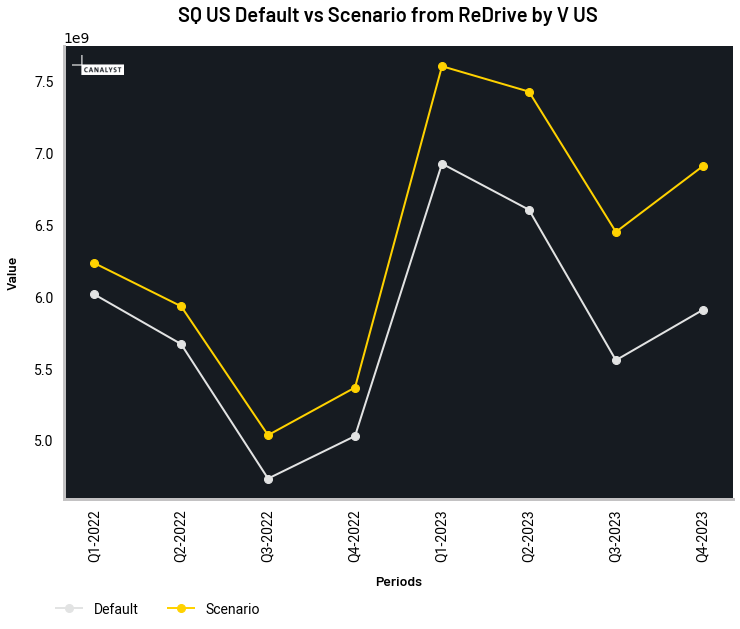

In [23]:
chart = cd.Chart(
    x_value=df_output["period_name"],
    y_values=df_output[['default','scenario']],
    labels=['Default','Scenario'],
    axis_labels=[["Periods", "Value"]],
    title=target_ticker+' Default vs Scenario from ReDrive by '+source_ticker,
)
chart.show()